In [1]:
import pandas as pd
import os
from scipy.interpolate import PchipInterpolator
import numpy as np
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import matplotlib.pyplot as plt

In [60]:
def graph_fases(array):
    plt.plot(np.angle(np.fft.rfft(array)),',')
    plt.title('Fases',fontsize=8)
    plt.xlabel('Frecuencias')
    plt.ylabel('Ángulos')
    plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def arm_detector(data, num_ventanas=25, b=0.6):
    n = len(data)
    x = np.arange(n)
    
    # Calcular el tamaño de cada ventana
    window_size = n // num_ventanas

    # Lista para almacenar los porcentajes de puntos dentro de las regiones
    porcentajes = []

    # Ajustar y graficar el ajuste lineal por cada ventana con las líneas paralelas
    for i in range(0, n, window_size):
        end = i + window_size
        if end > n:
            end = n
        
        x_window = x[i:end].reshape(-1, 1)
        y_window = data[i:end]
        
        # Crear y ajustar el modelo de regresión lineal
        modelo = LinearRegression()
        modelo.fit(x_window, y_window)
        
        # Obtener la pendiente y la intersección de la recta ajustada
        pendiente = modelo.coef_[0]
        interseccion = modelo.intercept_
        
        # Predecir valores ajustados
        y_pred = modelo.predict(x_window)
                
        # Calcular las rectas paralelas desplazadas por 'b'
        y_paralela_superior = pendiente * x_window + (interseccion + b)
        y_paralela_inferior = pendiente * x_window + (interseccion - b)
                
        # Calcular el porcentaje de datos dentro de la región delimitada por las líneas paralelas
        dentro_region = np.sum((y_window >= y_paralela_inferior.flatten()) & (y_window <= y_paralela_superior.flatten()))
        fuera_region = len(y_window) - dentro_region
        
        # Calcular el porcentaje de datos dentro de la región respecto a los datos fuera de la región
        porcentaje = (dentro_region * 100)/(dentro_region + fuera_region)
        porcentajes.append(porcentaje)

    def indice_mayor_90(arr):
        n = len(arr)
    
        # Revisar cada índice para encontrar el primero que cumpla la condición
        for i in range(n):
            if np.all(arr[i:] > 80) and len(arr[i:]) > 4:
                return i
        # Si no hay tal índice, regresar el último índice
        return n - 1
    
    indice = indice_mayor_90(np.array(porcentajes))*window_size
    return indice

def J_univariante(X,tau, corte):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    x1 = X[tau:]
    y1 = X[:-tau]
    ff1 = np.angle(np.fft.rfft(x1))
    ff2 = np.angle(np.fft.rfft(y1))
    if corte:
        print(len(ff1),len(ff2))
        transition_point1 = arm_detector(ff1)
        transition_point2 = arm_detector(ff2)
        if transition_point1 != transition_point2:
            transition_point1 = transition_point2 = min(transition_point1, transition_point2)
        ff2 = ff2[:transition_point2]
        ff1 = ff1[:transition_point1]
        print(len(ff1),len(ff2))
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2 = cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos = []
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        if np.linalg.norm(v1) == 0:
            v1_norm = v1
        else:
             v1_norm=v1/np.linalg.norm(v1)
        if np.linalg.norm(v2) == 0:
            v2_norm = v2
        else:
            v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)

    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J, angulos

In [4]:
def J_bivariante(X,Y,fases):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    ff1 = np.angle(np.fft.rfft(X))[:fases]
    ff2 = np.angle(np.fft.rfft(Y))[:fases]
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2=cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos=[]
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        v1_norm=v1/np.linalg.norm(v1)
        v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J

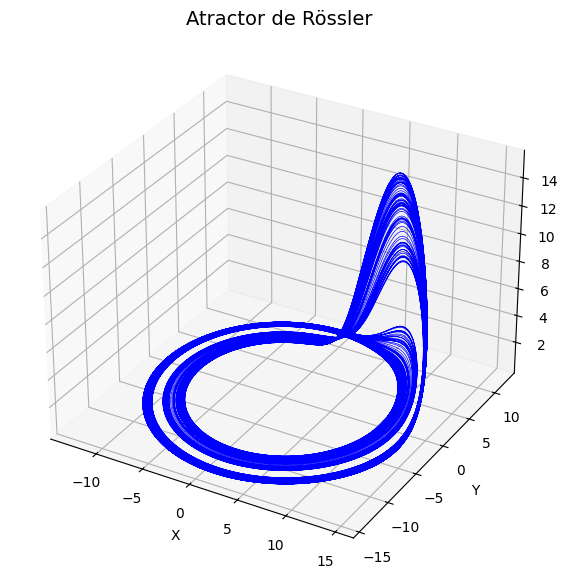

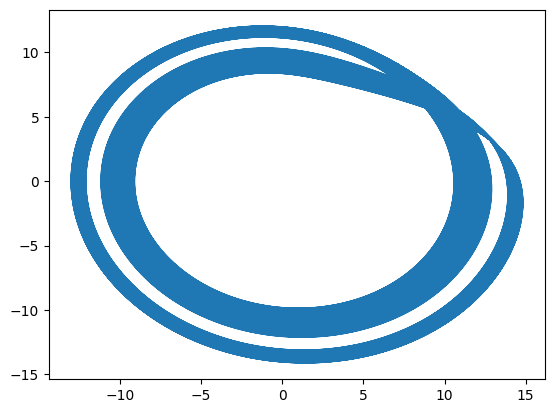

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del sistema
a = 0.1
b = 0.1
c = 9.0
dt = 0.01  # Paso de integración
transitorio = 10000  # Tiempo en pasos para eliminar el transitorio
total_puntos = 100000  # Número total de pasos

# Función del sistema de Rössler
def rossler_system(state, a, b, c):
    x, y, z = state
    dx = -y - z
    dy = x + a * y
    dz = b + z * (x - c)
    return np.array([dx, dy, dz])

# Método de Runge-Kutta de cuarto orden
def runge_kutta_step(state, dt, a, b, c):
    k1 = rossler_system(state, a, b, c)
    k2 = rossler_system(state + 0.5 * dt * k1, a, b, c)
    k3 = rossler_system(state + 0.5 * dt * k2, a, b, c)
    k4 = rossler_system(state + dt * k3, a, b, c)
    return state + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

# Condición inicial
initial_state = np.array([1.0, 1.0, 1.0])

# Inicialización de arrays para almacenar resultados
states = np.zeros((total_puntos, 3))
states[0] = initial_state

# Integración numérica
for i in range(1, total_puntos):
    states[i] = runge_kutta_step(states[i - 1], dt, a, b, c)

# Eliminar el transitorio
states = states[transitorio:]

# Extraer coordenadas x, y, z
x, y, z = states[:, 0], states[:, 1], states[:, 2]

# Graficar el atractor
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=0.5, color='blue')
ax.set_title("Atractor de Rössler", fontsize=14)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()
plt.plot(x,y)


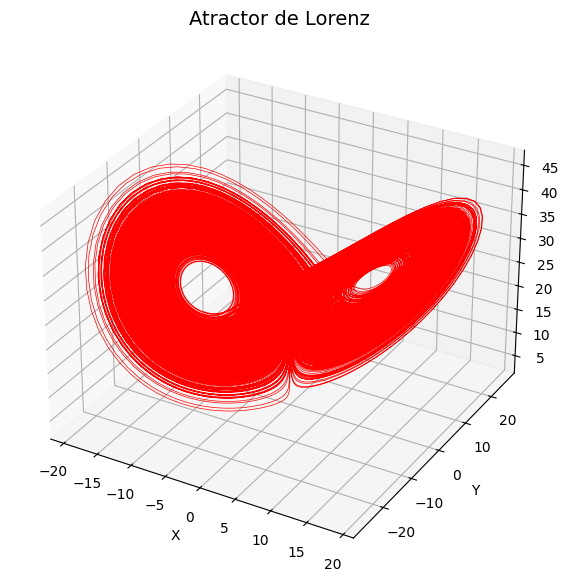

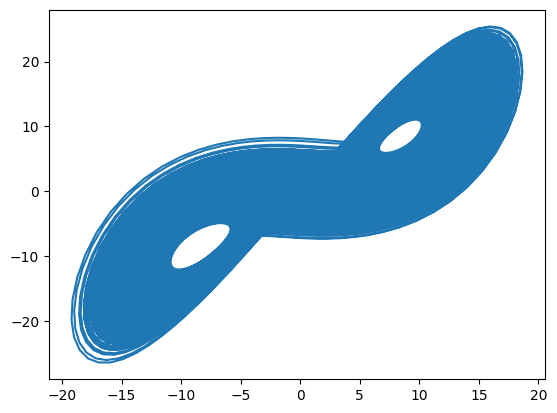

In [167]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del sistema
sigma = 10.0  # Parámetro sigma
beta = 8.0 / 3.0  # Parámetro beta
rho = 28.0  # Parámetro rho
dt = 0.01  # Paso de integración
transitorio = 15000  # Tiempo en pasos para eliminar el transitorio
total_puntos = 100000  # Número total de pasos

# Función del sistema de Lorenz
def lorenz_system(state, sigma, beta, rho):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.array([dx, dy, dz])

# Método de Runge-Kutta de cuarto orden
def runge_kutta_step(state, dt, sigma, beta, rho):
    k1 = lorenz_system(state, sigma, beta, rho)
    k2 = lorenz_system(state + 0.5 * dt * k1, sigma, beta, rho)
    k3 = lorenz_system(state + 0.5 * dt * k2, sigma, beta, rho)
    k4 = lorenz_system(state + dt * k3, sigma, beta, rho)
    return state + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

# Condición inicial
initial_state = np.array([1.0, 1.0, 1.0])

# Inicialización de arrays para almacenar resultados
states = np.zeros((total_puntos, 3))
states[0] = initial_state

# Integración numérica
for i in range(1, total_puntos):
    states[i] = runge_kutta_step(states[i - 1], dt, sigma, beta, rho)

# Eliminar el transitorio
states = states[transitorio:]

# Extraer coordenadas x, y, z
x, y, z = states[:, 0], states[:, 1], states[:, 2]

# Graficar el atractor
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=0.5, color='red')
ax.set_title("Atractor de Lorenz", fontsize=14)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()
plt.plot(x,y)
plt.show()


In [6]:
def generar_uniforme_centrada(n, varianza):
    # Calcular el límite superior e inferior de la distribución uniforme
    limite = np.sqrt(varianza)
    # Generar n números aleatorios con distribución uniforme entre -limite y limite
    return np.random.uniform(-limite, limite, n)

In [203]:
ruido

[0.0036684636267285686,
 0.003669639967033289,
 0.0039963375595553075,
 0.003672703361308205,
 0.00740739105995325,
 0.015477869321519844,
 0.04131538143684588,
 0.09906836281674014,
 0.25298223167544476,
 0.4651832530935095,
 0.6247239675676634,
 0.8437501641876951,
 0.886929633678386,
 0.9275590133049167,
 0.9323718647928515]

In [7]:
import numpy as np

def find_near_zero_index(array, tolerance=1e-6):
    """
    Encuentra el índice en un array donde todos los valores posteriores son cercanos a cero.

    Args:
        array (list o np.array): El array de entrada.
        tolerance (float): El umbral para considerar un valor como cercano a cero.

    Returns:
        int: El índice donde los valores posteriores son cercanos a cero, o -1 si no se encuentra.
    """
    array = np.array(array)  # Asegurar que es un array de numpy
    for i in range(len(array)):
        if np.all(np.abs(array[i:]) < tolerance):
            return i
    return -1  # Retorna -1 si no se cumple la condición

45000 45000
43200 43200
uni-autocorte 0.9623166142225442
bi-corte 0.41313253576083986


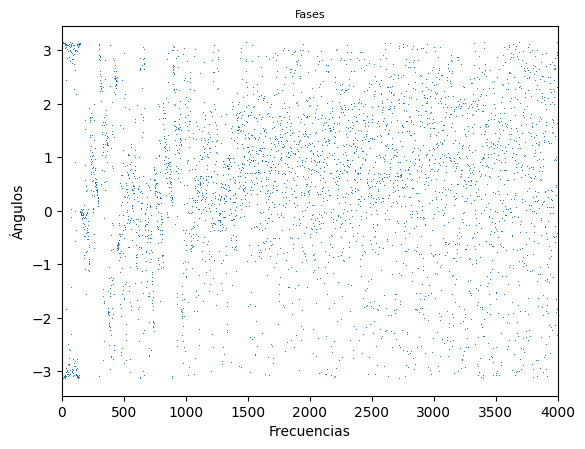

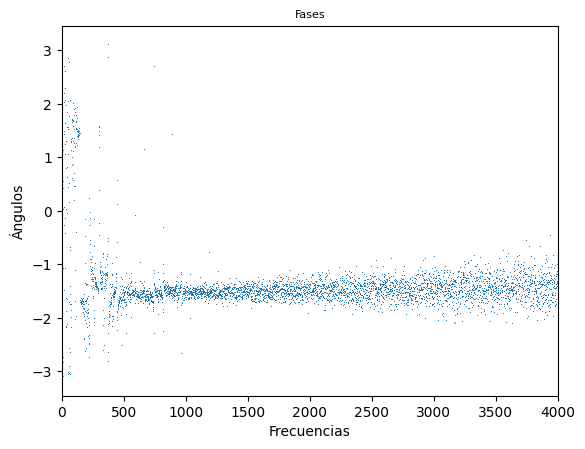

[3.02838523e+07 1.78083688e+06 1.72973599e+06 ... 1.78358267e+02
 9.08187021e+01 1.57315576e+02]
ha -1


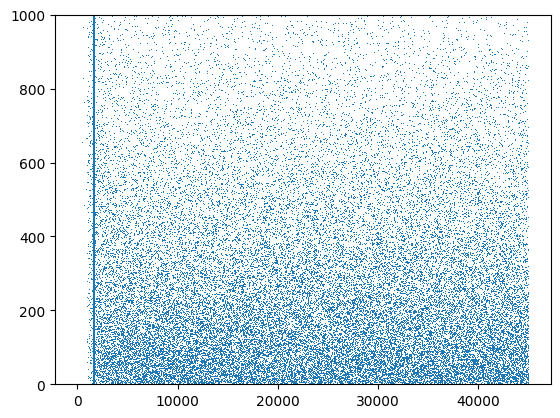

In [85]:
var = 1e-2
x_ruidoso = x + generar_uniforme_centrada(len(x), var)
y_ruidoso = y + generar_uniforme_centrada(len(y), var)
# x_ruidoso = np.sin(np.linspace(-25,25,1000))
J = J_bivariante(x_ruidoso,y_ruidoso,1000)
print('uni-autocorte', J_univariante(x_ruidoso, 1,True)[0])
print('bi-corte',J)
# plt.plot(np.angle(np.fft.rfft(x)),np.angle(np.fft.rfft(y)),'.')
plt.show()
plt.xlim(0,4000)
graph_fases(x_ruidoso[:])
plt.xlim(0,4000)
graph_fases(y_ruidoso[:])
plt.plot((np.abs(np.fft.rfft(x_ruidoso)))**2,',')
plt.axvline(1700)
plt.ylim(0,1000)
# plt.xlim(10000,15000)
af = find_near_zero_index(np.abs(np.fft.rfft(x_ruidoso))**2, tolerance=0.2)
print(np.abs(np.fft.rfft(x_ruidoso))**2)
print('ha', af)
plt.show()
# ruido.append(J)

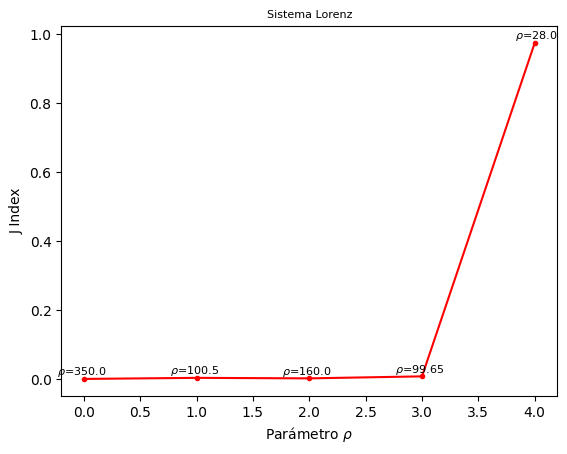

In [32]:
rho_values = [350.0, 100.5, 160.0, 99.65, 28.0]  # Valores de c correspondientes
Js_lorenz = [0.0007187192258479858,
 0.0038119615033079812,
 0.0023211682251085275,
 0.008150909636839954,
 0.9749492743626907]
# Graficar
plt.plot(Js_lorenz, color='red', marker='.', linestyle='-', label='Índice J')
plt.xlabel(r'Parámetro $\rho$')
plt.ylabel('J Index')
plt.title('Sistema Lorenz', fontsize=8)

# Añadir etiquetas
for i, (x, c) in enumerate(zip(range(len(rho_values)), rho_values)):
    plt.text(x+0.2, Js_lorenz[i], fr'$\rho$={c}', fontsize=8, ha='right', va='bottom')

plt.show()

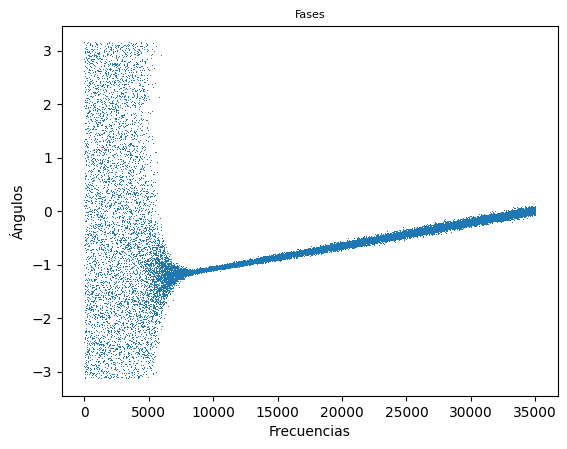

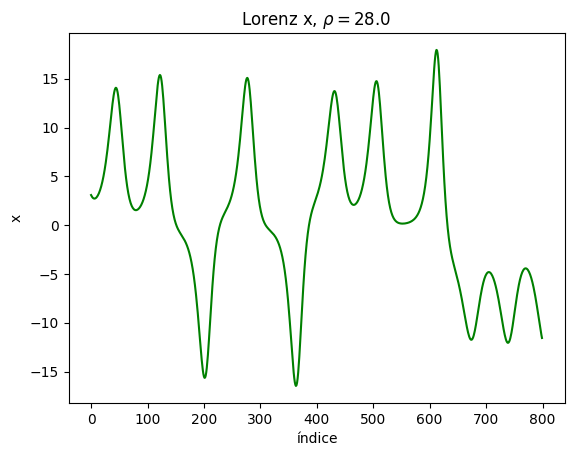

0.9788358975578227

In [86]:
x = np.loadtxt('lorenz_x_28.0.txt')
y = np.loadtxt('lorenz_y_28.0.txt')
graph_fases(x+generar_uniforme_centrada(len(x), 1e-6))
plt.plot(x[:800], 'green')
plt.title(r'Lorenz x, $\rho = 28.0$')
plt.xlabel('índice')
plt.ylabel('x')
plt.show()
J_bivariante(x,y,5000)

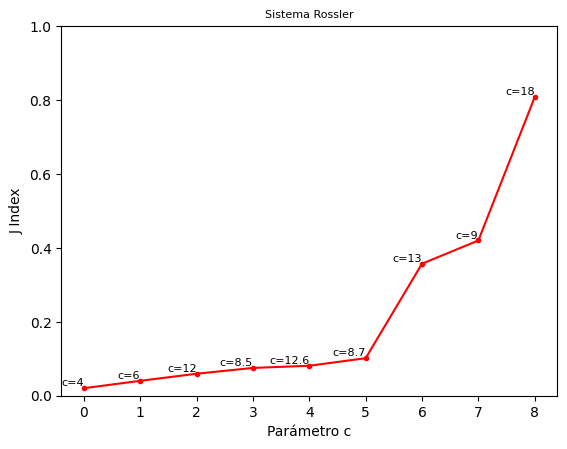

In [28]:
c_values = [4, 6, 12, 8.5, 12.6, 8.7, 13, 9, 18]  # Valores de c correspondientes
Js_rossler = [0.0203,
 0.0403,
 0.0595,
 0.0752,
 0.0811,
 0.1015,
 0.35713,
 0.42,
 0.8079997579775595]
# Graficar
plt.plot(Js_rossler, color='red', marker='.', linestyle='-', label='Índice J')
plt.xlabel('Parámetro c')
plt.ylabel('J Index')
plt.ylim(0,1.0)
plt.title('Sistema Rossler', fontsize=8)

# Añadir etiquetas
for i, (x, c) in enumerate(zip(range(len(c_values)), c_values)):
    plt.text(x, Js_rossler[i], f'c={c}', fontsize=8, ha='right', va='bottom')

plt.show()

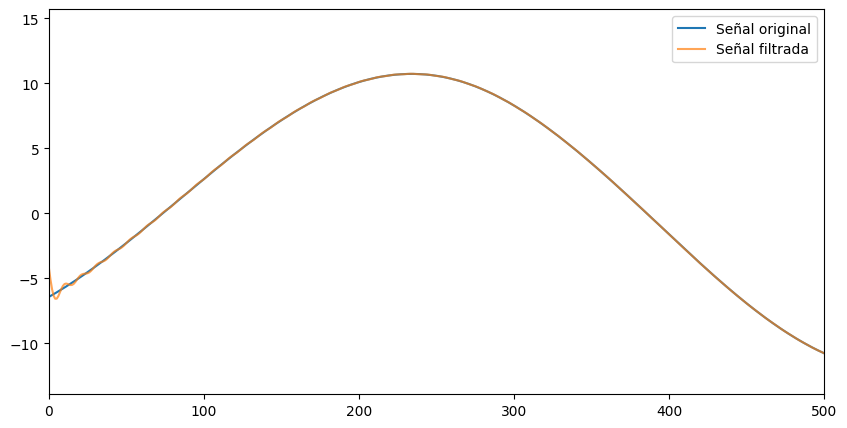

0.9999987478498026


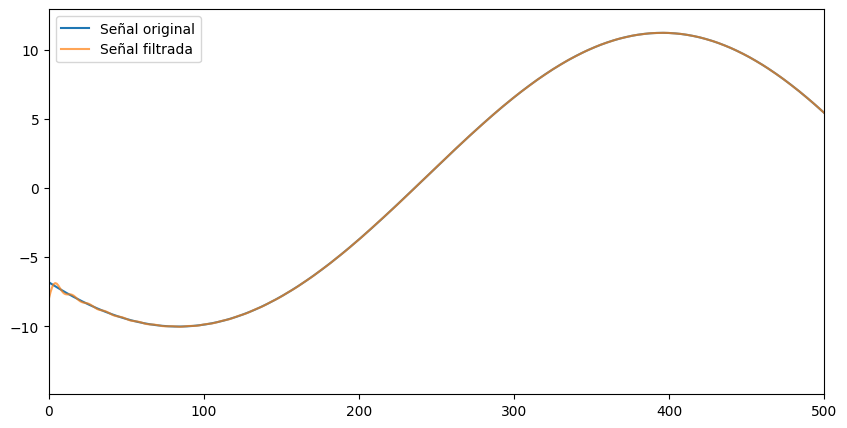

0.9999993843888718


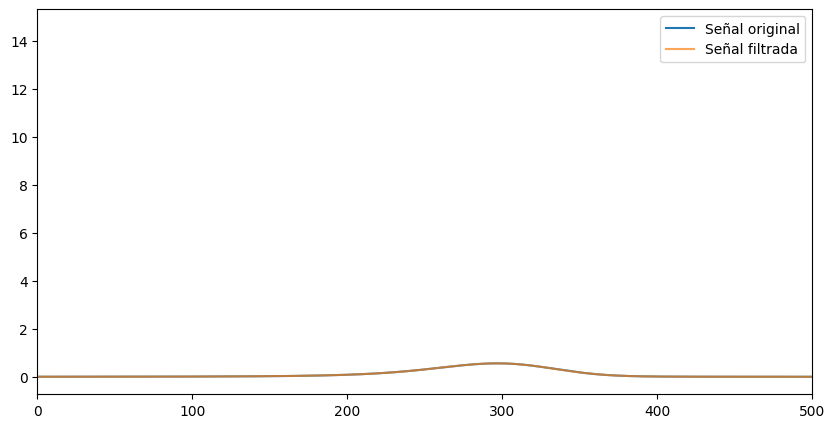

0.9999989145342528


In [192]:
import numpy as np
import matplotlib.pyplot as plt

# Definir parámetros
cutoff = 3500  # Frecuencia de corte en índice
for i,cutoff,label in zip([x,y,z],[8000,8000,8000],['x','y','z']):
    fft_signal = np.fft.rfft(i)  # Transformada de Fourier

    # Aplicar filtro pasa-bajas
    filtered_fft = fft_signal.copy()
    filtered_fft[cutoff:] = 0  # Eliminar frecuencias altas

    # Transformada inversa
    filtered_signal = np.fft.irfft(filtered_fft)

    # Visualizar señal original y filtrada
    plt.figure(figsize=(10, 5))
    plt.plot(i, label="Señal original")
    plt.plot(filtered_signal, label="Señal filtrada", alpha=0.7)
    plt.xlim(0,500)
    plt.legend()
    plt.show()
    print(spearmanr(filtered_signal, i)[0])
    # if label == 'x':
    #     x = filtered_signal
    # if label == 'y':
    #     y = filtered_signal
    # if label == 'z':
    #     z = filtered_signal